In [67]:
!pip3 install seaborn
!pip3 install pillow
!brew install tensorflow
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install tqdm

You should consider upgrading via the '/Users/hemangj/Desktop/Programing/BlindNessDetection/blindnessDetect/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hemangj/Desktop/Programing/BlindNessDetection/blindnessDetect/bin/python3 -m pip install --upgrade pip' command.
To reinstall 2.19.0, run:
  brew reinstall libtensorflow
You should consider upgrading via the '/Users/hemangj/Desktop/Programing/BlindNessDetection/blindnessDetect/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/hemangj/Desktop/Programing/BlindNessDetection/blindnessDetect/bin/python3 -m pip install --upgrade pip' command.
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
You should consider upgrading via the '/Users/hemangj/Desktop/Programing/BlindNessDetection/blindnessDetect/bin/python3 -m pip install --upgrade pip' command.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from rich.progress import track
from rich.console import Console
from rich import box
from rich.table import Table
from rich.panel import Panel
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from PIL import Image
import cv2
import os

In [22]:
# Print Files In Current Directory
os.listdir()

# Creating Console Object
console = Console()

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [5]:
print(f"The Shape of Train Set :- {df_train.shape}")
print(f"The Shape of Testing Set :- {df_test.shape}")

print(f"Total Data we have :- ({df_train.shape[0] + df_test.shape[0]},{df_train.shape[1] + df_test.shape[1]})")

The Shape of Train Set :- (3662, 2)
The Shape of Testing Set :- (1928, 1)
Total Data we have :- (5590,3)


In [6]:
print(f"Total Number of Images Identified for Training {len(os.listdir('train_images'))}")
print(f"Total Number of Images Identified for Testing {len(os.listdir('test_images'))}")

print(f"Total Number of Images Identified {len(os.listdir('train_images'))+len(os.listdir('test_images'))}")

Total Number of Images Identified for Training 3662
Total Number of Images Identified for Testing 1929
Total Number of Images Identified 5591


In [7]:
# Label Mapping To Understand Each Label Properly
label_map = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

# 👁️ APTOS 2019 Blindness Detection - Exploratory Data Analysis (EDA)

Welcome to the Exploratory Data Analysis for the **APTOS 2019 Blindness Detection** competition.  
The goal of this competition is to identify the severity of diabetic retinopathy in retinal images.

In this notebook, we will:
- Understand the structure of the dataset 📁
- Explore class distribution and imbalance ⚖️
- Visualize sample retinal images 🖼️
- Analyze metadata and patterns 📊

Let's dive in! 🔍


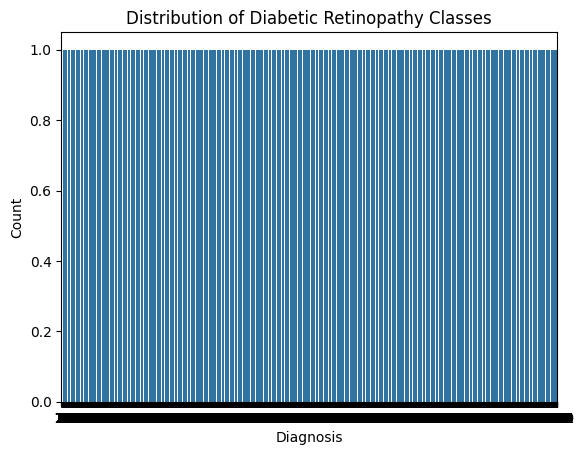

In [22]:
sns.countplot(df_train['diagnosis'])
plt.title("Distribution of Diabetic Retinopathy Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

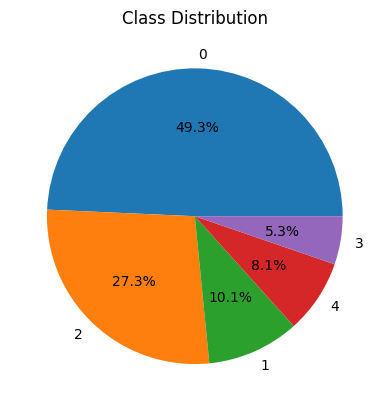

In [23]:
df_train['diagnosis'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%')
plt.title("Class Distribution")
plt.ylabel("")
plt.show()

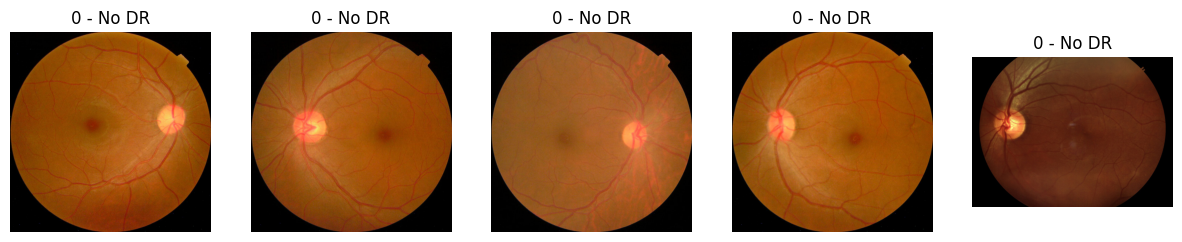

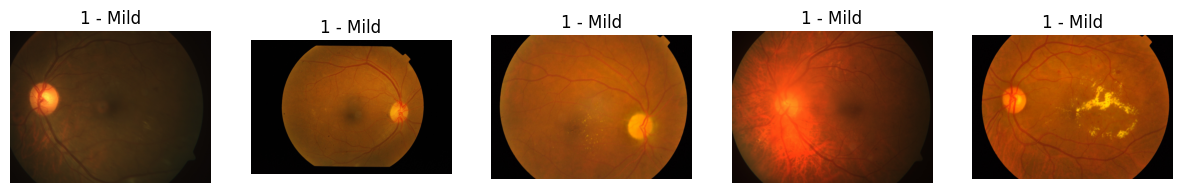

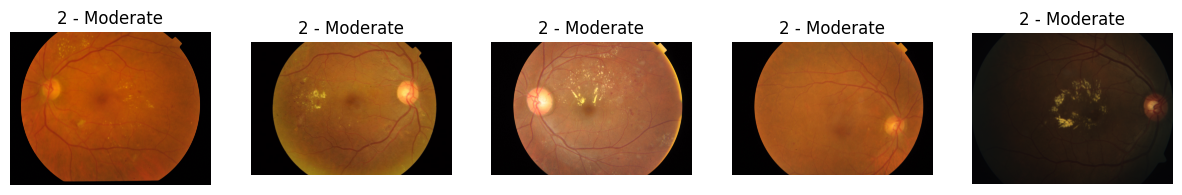

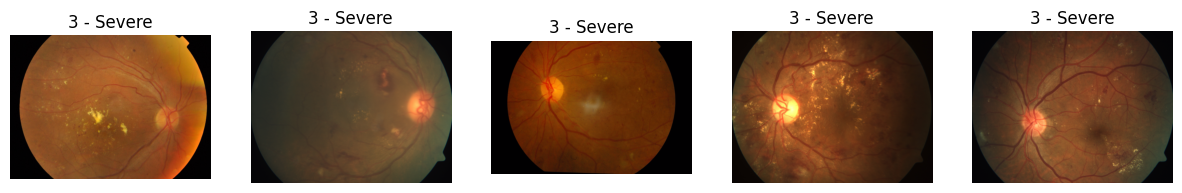

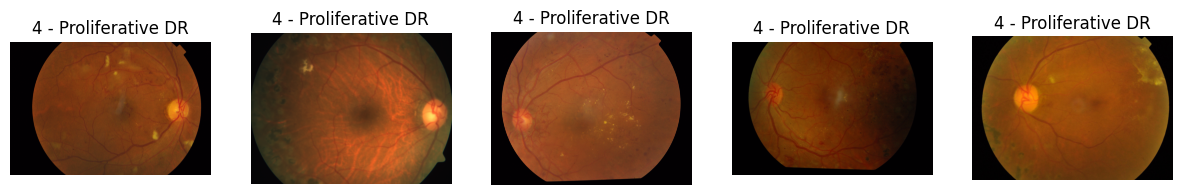

In [31]:
def show_images(df, label, n=5, folder='train_images'):
    samples = df[df['diagnosis'] == label].sample(n)
    label_name = label_map[label]
    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(samples['id_code']):
        path = os.path.join(folder, img_id + ".png")
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{label} - {label_name}")
        plt.axis('off')
    plt.show()

for label in sorted(df_train['diagnosis'].unique()):
    show_images(df_train, label)


In [27]:
img_shapes = []

for img_id in df_train['id_code'].sample(500):
    img = Image.open(f"train_images/{img_id}.png")
    img_shapes.append(img.size)

sizes = pd.DataFrame(img_shapes, columns=["width", "height"])
sizes.describe()


,width,height
count,500.000000,500.00000
mean,2012.804000,1520.78800
std,874.096438,530.26614
min,474.000000,358.00000
25%,1050.000000,1050.00000
50%,2416.000000,1736.00000
75%,2588.000000,1958.00000
max,4288.000000,2848.00000


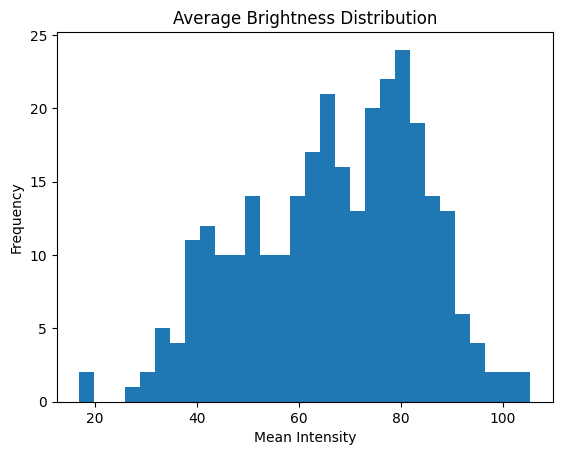

In [29]:
def brightness_histogram(image_paths):
    avg_brightness = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            avg_brightness.append(np.mean(img))
    plt.hist(avg_brightness, bins=30)
    plt.title("Average Brightness Distribution")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Frequency")
    plt.show()

sample_paths = [f"train_images/{i}.png" for i in df_train['id_code'].sample(300)]
brightness_histogram(sample_paths)

## 🔧 Preprocessing Strategy

Based on image size variation, brightness inconsistency, and class imbalance, the following preprocessing steps are applied:

1. **Resizing** all images to 224×224 resolution.
2. **Center cropping** or padding to maintain retina focus.
3. **CLAHE (Contrast Limited Adaptive Histogram Equalization)** for brightness normalization.
4. **Circular masking** to remove non-retinal background.
5. **Pixel normalization** using ImageNet standards.
6. **Data augmentation** to balance underrepresented classes using rotation, flips, and color jittering.

These steps ensure uniform input quality and help the model generalize better.


In [37]:
def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

In [38]:
def pad_to_square(img, color=(0, 0, 0)):
    h, w = img.shape[:2]
    size = max(h, w)
    delta_w = size - w
    delta_h = size - h
    top, bottom = delta_h // 2, delta_h - delta_h // 2
    left, right = delta_w // 2, delta_w - delta_w // 2
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

In [39]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

In [40]:
def apply_circular_crop(img):
    h, w = img.shape[:2]
    center = (w//2, h//2)
    radius = min(center[0], center[1])
    mask = np.zeros((h, w), np.uint8)
    cv2.circle(mask, center, radius, (1,), thickness=-1)
    masked = cv2.bitwise_and(img, img, mask=mask)
    return masked

In [41]:
def normalize_image(img):
    return img.astype(np.float32) / 255.0

In [42]:
def preprocess_image(img_path, size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = pad_to_square(img)
    img = resize_image(img, size)
    img = apply_circular_crop(img)
    img = apply_clahe(img)
    img = normalize_image(img)
    return img

In [43]:
def process_all_images(input_dir, output_dir, size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)
    images = [f for f in os.listdir(input_dir) if f.endswith('.png') or f.endswith('.jpg')]

    console.print(Panel.fit("[bold green]Starting Preprocessing of Retina Images[/bold green]"))

    for filename in track(images, description="🧪 Processing images..."):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        img = preprocess_image(input_path, size)
        if img is not None:
            img_uint8 = (img * 255).astype(np.uint8)
            img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, img_bgr)

    console.print("\n✅ [bold cyan]All images processed and saved to:[/bold cyan]", output_dir)

    table = Table(title="Preprocessing Summary", box=box.ROUNDED)
    table.add_column("Input Dir", justify="center")
    table.add_column("Output Dir", justify="center")
    table.add_column("Image Count", justify="center")
    table.add_row(input_dir, output_dir, str(len(images)))
    console.print(table)

In [73]:
# Processing Training Data
process_all_images("train_images","train_images_processed")

🧪 Processing images... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:03:40

✅ All images processed and saved to: train_images_processed

                 Preprocessing Summary                 
╭──────────────┬────────────────────────┬─────────────╮
│  Input Dir   │       Output Dir       │ Image Count │
├──────────────┼────────────────────────┼─────────────┤
│ train_images │ train_images_processed │    3662     │
╰──────────────┴────────────────────────┴─────────────╯

In [52]:
# Processing Testing Data
process_all_images("test_images","test_images_processed")

╭─────────────────────────────────────────╮
│ Starting Preprocessing of Retina Images │
╰─────────────────────────────────────────╯

✅ All images processed and saved to: test_images_processed

                Preprocessing Summary                
╭─────────────┬───────────────────────┬─────────────╮
│  Input Dir  │      Output Dir       │ Image Count │
├─────────────┼───────────────────────┼─────────────┤
│ test_images │ test_images_processed │    1928     │
╰─────────────┴───────────────────────┴─────────────╯

In [12]:
from itertools import product

search_space = {
    "lr": [1e-3, 1e-4],
    "optimizer": ["adam", "sgd"],
    "batch_size": [16, 32],
    "epochs": [10, 25]  # good balance between speed and performance
}

grid = list(product(*search_space.values()))

In [13]:
def build_model(input_shape=(224, 224, 3), num_classes=5, lr=1e-3, optimizer_name="adam"):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    opt = optimizers.Adam(learning_rate=lr) if optimizer_name == "adam" else optimizers.SGD(learning_rate=lr)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [14]:
def run_kfold_grid_search(df, X, y, input_shape, num_classes=5, n_splits=5):
    results = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for params in grid:
        lr, opt, batch_size, epochs = params
        print(f"\n🔍 Testing Config: LR={lr}, OPT={opt}, BATCH={batch_size}, EPOCHS={epochs}")
        fold_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"▶️ Fold {fold+1}/{n_splits}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = build_model(input_shape, num_classes, lr, opt)
            model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
            loss, acc = model.evaluate(X_val, y_val, verbose=0)
            fold_accuracies.append(acc)

        avg_acc = np.mean(fold_accuracies)
        results.append((params, avg_acc))
        print(f"✅ Avg Val Accuracy: {avg_acc:.4f}")

    best = sorted(results, key=lambda x: x[1], reverse=True)[0]
    print(f"\n🏆 Best Config: {best[0]} → Accuracy: {best[1]:.4f}")
    return best


In [15]:
def load_dataset_from_folder(df, image_folder, target_size=(224, 224)):
    """
    Load preprocessed images and labels into numpy arrays.
    """
    X, y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_id = row['id_code']
        label = row['diagnosis']
        image_path = os.path.join(image_folder, image_id + ".png")

        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img.astype(np.float32) / 255.0

        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

In [16]:
## Loading Train DataSet
X, y = load_dataset_from_folder(df_train, "train_images_processed")

100%|████████████████████████████| 3662/3662 [00:04<00:00, 837.96it/s]


In [17]:
# Input shape for model
input_shape = (224, 224, 3)

# Run it
best_config = run_kfold_grid_search(df_train, X, y, input_shape=input_shape, num_classes=5)


🔍 Testing Config: LR=0.001, OPT=adam, BATCH=16, EPOCHS=10
▶️ Fold 1/5


KeyboardInterrupt: 

## 🧠 Transfer Learning with Pretrained CNNs

Now that we've established a baseline using a custom CNN, it's time to explore transfer learning using **pretrained models**. These models are trained on large datasets like **ImageNet**, and can help improve performance on medical image tasks like APTOS.

We will experiment with the following pretrained architectures:

- 🧠 `MobileNetV2`
- ⚡ `EfficientNetB0`
- 🔎 `ResNet50`

Each model will be:
- Initialized with pretrained ImageNet weights
- Modified to fit our 5-class output
- Trained using stratified K-Fold cross-validation
- Evaluated using the same grid of hyperparameters

Our goal is to identify which pretrained model yields the best validation accuracy.


In [ ]:
def get_pretrained_model(model_name, input_shape=(224, 224, 3), num_classes=5):
    base_model = None

    if model_name == "mobilenetv2":
        base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "efficientnetb0":
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    elif model_name == "resnet50":
        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    base_model.trainable = False  # freeze base for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base_model.input, outputs=outputs)

In [ ]:
def run_kfold_grid_search_with_pretrained(X, y, model_name, input_shape=(224, 224, 3), num_classes=5, n_splits=5):
    results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    console.rule(f"[bold blue]🚀 Starting Grid Search for [green]{model_name.upper()}[/green]")

    for params in grid:
        lr, opt, batch_size, epochs = params
        config_name = f"LR={lr}, OPT={opt.upper()}, BATCH={batch_size}, EPOCHS={epochs}"
        console.print(Panel.fit(f"[bold yellow]Testing Config[/bold yellow]\n{config_name}"))

        fold_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=n_splits, desc=f"[{model_name}] ⏳ Folds")):
            console.print(f"[blue]▶️ Fold {fold+1}/{n_splits}[/blue]")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = get_pretrained_model(model_name, input_shape=input_shape, num_classes=num_classes)
            opt_fn = tf.keras.optimizers.Adam(learning_rate=lr) if opt == "adam" else tf.keras.optimizers.SGD(learning_rate=lr)
            model.compile(optimizer=opt_fn, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

            model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
            _, acc = model.evaluate(X_val, y_val, verbose=0)

            console.print(f"✅ [green]Fold {fold+1} Accuracy:[/green] {acc:.4f}")
            fold_accuracies.append(acc)

        avg_acc = np.mean(fold_accuracies)
        results.append((params, avg_acc))
        console.print(f"[bold cyan]🏁 Avg Val Accuracy for {config_name}: {avg_acc:.4f}[/bold cyan]")

    best = sorted(results, key=lambda x: x[1], reverse=True)[0]
    console.rule(f"[bold green]🏆 Best Config for {model_name.upper()}[/bold green]")
    console.print(f"[bold magenta]{best[0]}[/bold magenta] → [bold white]Avg Accuracy:[/bold white] {best[1]:.4f}")

    # Table summary
    table = Table(title="Top Configs", show_lines=True)
    table.add_column("LR")
    table.add_column("OPT")
    table.add_column("Batch")
    table.add_column("Epochs")
    table.add_column("Val Acc")

    for config, score in sorted(results, key=lambda x: x[1], reverse=True)[:5]:
        lr, opt, bs, ep = config
        table.add_row(str(lr), opt, str(bs), str(ep), f"{score:.4f}")

    console.print(table)

    return best

In [ ]:
# Second Efficientnetb0
run_kfold_grid_search_with_pretrained(X, y, model_name="efficientnetb0")

In [23]:
##### First MobileNetV2
run_kfold_grid_search_with_pretrained(X, y, model_name="mobilenetv2")

───────────────────────────────────── 🚀 Starting Grid Search for MOBILENETV2 ─────────────────────────────────────

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=10 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7763

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [03:03<12:15, 183.99s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7913

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [06:09<09:15, 185.06s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7814

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [09:00<05:57, 178.73s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7869

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [11:48<02:54, 174.16s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7746

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [14:43<00:00, 176.61s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=10: 0.7821

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=25 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7694

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [06:47<27:08, 407.16s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7954

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [13:33<20:20, 406.89s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.8019

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [20:12<13:26, 403.02s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7787

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [26:46<06:39, 399.37s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7746

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [33:16<00:00, 399.33s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=25: 0.7840

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.001, OPT=ADAM, BATCH=32, EPOCHS=10 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7899

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [02:49<11:18, 169.62s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.8035

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [05:35<08:22, 167.46s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7896

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [08:21<05:33, 166.61s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7883

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [11:05<02:45, 165.59s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7746

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [13:51<00:00, 166.38s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=ADAM, BATCH=32, EPOCHS=10: 0.7892

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.001, OPT=ADAM, BATCH=32, EPOCHS=25 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7831

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [06:42<26:49, 402.35s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7995

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [13:28<20:13, 404.66s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7855

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [19:50<13:08, 394.10s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7964

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [26:11<06:28, 388.96s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7869

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [32:26<00:00, 389.34s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=ADAM, BATCH=32, EPOCHS=25: 0.7903

╭────────────────────────────────────────╮
│ Testing Config                         │
│ LR=0.001, OPT=SGD, BATCH=16, EPOCHS=10 │
╰────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7408

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [03:19<13:19, 199.80s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7394

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [07:26<11:21, 227.26s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7486

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [11:51<08:08, 244.37s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7596

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [16:07<04:09, 249.11s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7295

[mobilenetv2] ⏳ Folds: 100%|██████| 5/5 [12:32:24<00:00, 9028.88s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=SGD, BATCH=16, EPOCHS=10: 0.7436

╭────────────────────────────────────────╮
│ Testing Config                         │
│ LR=0.001, OPT=SGD, BATCH=16, EPOCHS=25 │
╰────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7435

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [08:39<34:39, 519.86s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7722

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [14:46<21:29, 429.68s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7596

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [20:40<13:09, 394.98s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7773

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [26:45<06:23, 383.19s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7691

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [32:55<00:00, 395.02s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=SGD, BATCH=16, EPOCHS=25: 0.7643

╭────────────────────────────────────────╮
│ Testing Config                         │
│ LR=0.001, OPT=SGD, BATCH=32, EPOCHS=10 │
╰────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7285

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [02:45<11:03, 165.79s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7381

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [05:26<08:08, 162.80s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7295

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [08:02<05:19, 159.64s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7350

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [10:39<02:38, 158.50s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7309

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [13:15<00:00, 159.18s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=SGD, BATCH=32, EPOCHS=10: 0.7324

╭────────────────────────────────────────╮
│ Testing Config                         │
│ LR=0.001, OPT=SGD, BATCH=32, EPOCHS=25 │
╰────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7626

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [06:47<27:09, 407.44s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7681

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [13:34<20:21, 407.15s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7609

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [20:12<13:25, 402.97s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7596

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [26:45<06:39, 399.18s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7418

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [33:11<00:00, 398.25s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=SGD, BATCH=32, EPOCHS=25: 0.7586

╭──────────────────────────────────────────╮
│ Testing Config                           │
│ LR=0.0001, OPT=ADAM, BATCH=16, EPOCHS=10 │
╰──────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7572

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [02:33<10:12, 153.24s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7776

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [05:01<07:30, 150.03s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7596

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [07:44<05:12, 156.02s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7637

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [10:10<02:32, 152.05s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7500

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [12:31<00:00, 150.28s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=ADAM, BATCH=16, EPOCHS=10: 0.7616

╭──────────────────────────────────────────╮
│ Testing Config                           │
│ LR=0.0001, OPT=ADAM, BATCH=16, EPOCHS=25 │
╰──────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7708

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [05:35<22:20, 335.12s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7872

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [11:00<16:28, 329.64s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7814

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [16:29<10:57, 328.96s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7732

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [22:13<05:34, 334.95s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7787

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [27:53<00:00, 334.65s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=ADAM, BATCH=16, EPOCHS=25: 0.7783

╭──────────────────────────────────────────╮
│ Testing Config                           │
│ LR=0.0001, OPT=ADAM, BATCH=32, EPOCHS=10 │
╰──────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7353

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [02:27<09:50, 147.59s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7531

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [04:54<07:20, 146.99s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7404

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [07:21<04:54, 147.29s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7445

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [09:47<02:26, 146.67s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7473

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [12:16<00:00, 147.25s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=ADAM, BATCH=32, EPOCHS=10: 0.7441

╭──────────────────────────────────────────╮
│ Testing Config                           │
│ LR=0.0001, OPT=ADAM, BATCH=32, EPOCHS=25 │
╰──────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7681

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [05:56<23:46, 356.52s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7776

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [11:49<17:43, 354.40s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7650

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [17:44<11:49, 354.51s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7787

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [25:55<06:48, 408.54s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7705

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [34:25<00:00, 413.04s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=ADAM, BATCH=32, EPOCHS=25: 0.7720

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.0001, OPT=SGD, BATCH=16, EPOCHS=10 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.6753

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [02:31<10:05, 151.27s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.6985

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [04:55<07:20, 146.93s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.6735

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [07:10<04:42, 141.45s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7049

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [09:25<02:19, 139.15s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7022

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [11:38<00:00, 139.65s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=SGD, BATCH=16, EPOCHS=10: 0.6909

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.0001, OPT=SGD, BATCH=16, EPOCHS=25 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7135

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [05:20<21:22, 320.56s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7176

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [10:40<16:00, 320.08s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.7172

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [15:58<10:38, 319.00s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7227

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [21:09<05:16, 316.21s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.7172

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [26:28<00:00, 317.65s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=SGD, BATCH=16, EPOCHS=25: 0.7176

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.0001, OPT=SGD, BATCH=32, EPOCHS=10 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.6603

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [02:26<09:44, 146.22s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.6712

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [04:57<07:27, 149.24s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.6694

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [07:32<05:03, 151.85s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.6844

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [10:06<02:32, 152.69s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.6680

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [12:39<00:00, 151.87s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=SGD, BATCH=32, EPOCHS=10: 0.6707

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.0001, OPT=SGD, BATCH=32, EPOCHS=25 │
╰─────────────────────────────────────────╯

[mobilenetv2] ⏳ Folds:   0%|                   | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.7012

[mobilenetv2] ⏳ Folds:  20%|██        | 1/5 [06:11<24:46, 371.70s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.7040

[mobilenetv2] ⏳ Folds:  40%|████      | 2/5 [12:22<18:33, 371.12s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.6844

[mobilenetv2] ⏳ Folds:  60%|██████    | 3/5 [18:35<12:23, 371.97s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.7036

[mobilenetv2] ⏳ Folds:  80%|████████  | 4/5 [24:35<06:07, 367.43s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.6995

[mobilenetv2] ⏳ Folds: 100%|██████████| 5/5 [30:46<00:00, 369.32s/it]


🏁 Avg Val Accuracy for LR=0.0001, OPT=SGD, BATCH=32, EPOCHS=25: 0.6985

───────────────────────────────────────── 🏆 Best Config for MOBILENETV2 ──────────────────────────────────────────

(0.001, 'adam', 32, 25) → Avg Accuracy: 0.7903

                Top Configs                 
┏━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ LR     ┃ OPT  ┃ Batch ┃ Epochs ┃ Val Acc ┃
┡━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ 0.001  │ adam │ 32    │ 25     │ 0.7903  │
├────────┼──────┼───────┼────────┼─────────┤
│ 0.001  │ adam │ 32    │ 10     │ 0.7892  │
├────────┼──────┼───────┼────────┼─────────┤
│ 0.001  │ adam │ 16    │ 25     │ 0.7840  │
├────────┼──────┼───────┼────────┼─────────┤
│ 0.001  │ adam │ 16    │ 10     │ 0.7821  │
├────────┼──────┼───────┼────────┼─────────┤
│ 0.0001 │ adam │ 16    │ 25     │ 0.7783  │
└────────┴──────┴───────┴────────┴─────────┘

((0.001, 'adam', 32, 25), np.float64(0.7902779936790466))

In [ ]:
# Third ResNet50
run_kfold_grid_search_with_pretrained(X, y, model_name="resnet50")

────────────────────────────────────── 🚀 Starting Grid Search for RESNET50 ───────────────────────────────────────

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=10 │
╰─────────────────────────────────────────╯

[resnet50] ⏳ Folds:   0%|                      | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


✅ Fold 1 Accuracy: 0.5443

[resnet50] ⏳ Folds:  20%|██▌          | 1/5 [10:03<40:13, 603.46s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.5812

[resnet50] ⏳ Folds:  40%|█████▏       | 2/5 [19:51<29:42, 594.24s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.6011

[resnet50] ⏳ Folds:  60%|███████▊     | 3/5 [29:12<19:18, 579.19s/it]

▶️ Fold 4/5

✅ Fold 4 Accuracy: 0.5505

[resnet50] ⏳ Folds:  80%|██████████▍  | 4/5 [38:28<09:30, 570.15s/it]

▶️ Fold 5/5

✅ Fold 5 Accuracy: 0.5519

[resnet50] ⏳ Folds: 100%|█████████████| 5/5 [47:45<00:00, 573.01s/it]


🏁 Avg Val Accuracy for LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=10: 0.5658

╭─────────────────────────────────────────╮
│ Testing Config                          │
│ LR=0.001, OPT=ADAM, BATCH=16, EPOCHS=25 │
╰─────────────────────────────────────────╯

[resnet50] ⏳ Folds:   0%|                      | 0/5 [00:00<?, ?it/s]

▶️ Fold 1/5

✅ Fold 1 Accuracy: 0.6958

[resnet50] ⏳ Folds:  20%|██        | 1/5 [23:45<1:35:00, 1425.03s/it]

▶️ Fold 2/5

✅ Fold 2 Accuracy: 0.6849

[resnet50] ⏳ Folds:  40%|████      | 2/5 [48:18<1:12:40, 1453.58s/it]

▶️ Fold 3/5

✅ Fold 3 Accuracy: 0.6817

[resnet50] ⏳ Folds:  60%|██████    | 3/5 [1:11:40<47:39, 1429.78s/it]

▶️ Fold 4/5

In [ ]:
##### First MobileNetV2
run_kfold_grid_search_with_pretrained(X, y, model_name="efficentnetb0")